# Introduction

We start with defining the helper functions. The function `plot_prelogs` plots the (Euclidean) gradients of the squared correction function w.r.t. to given target. We choose the last point of the curve as the target. In other words it is $\nabla_x a^2(\cdot, y_{\text{last}})$. For Function `plot_geodesics` plots the interpolated geodesics between two points.

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def plot_dist_grads(points, manifold, eps, density):
    x = torch.linspace(points[:, 0].min() - eps, points[:, 0].max() + eps, density)
    y = torch.linspace(points[:, 1].min() - eps, points[:, 1].max() + eps, density)
    target = points[-1, :].reshape(-1, 1, 2)
    
    xv, yv = np.meshgrid(x, y)
    xy = np.vstack([xv.ravel(), yv.ravel()]).T
    ps = torch.from_numpy(xy[None])
    
    with torch.no_grad():
        total_prelogs, _, _, _, = manifold.prelog(ps, target)
        total_prelogs = total_prelogs.squeeze([0, 2]).detach().cpu().numpy()
    
    # initialize figure with only one ax
    fig, ax = plt.subplots(1, 1, figsize=(10, 10), dpi=50)
    
    ax.plot(points[:, 0], points[:, 1], label='True', color='black', alpha=0.5)
    # plot total prelogs
    total_prelogs_x = total_prelogs[:, 0]
    total_prelogs_y = total_prelogs[:, 1]
    ax.quiver(xv, yv, total_prelogs_x, total_prelogs_y, width=0.002, color='blue', label='Distance grads')
    
    # enable legend
    ax.legend()
    
def plot_geodesics(points, manifold, starting_idx, ending_idx, n_interps):
    # initialize figure with only one ax
    fig, ax = plt.subplots(1, 1, figsize=(10, 10), dpi=50)
    pts = points.unbind(dim=1)
    ax.plot(*pts, label='true', color='black', alpha=0.5)
    
    p0 = points[starting_idx][None, None]
    p1 = points[ending_idx][None, None]
    
    ts = torch.linspace(0, 1, n_interps)
    preds = torch.zeros(n_interps, p0.shape[-1])
    for i, t in enumerate(ts):
        t = torch.tensor([t], dtype=torch.float32)
        preds[i] = manifold.geodesic(p0, p1, t, debug=True,
                                                max_iter=500,
                                                step_size=0.1).squeeze()
    
    preds = preds.detach().unbind(dim=1)
    ax.scatter(*preds, s=8, label='predicted', color='blue')
    ax.legend()

Note that the helper functions use the manifold class, which follows Willem's convention and naming. I choose to represent the corrected manifolds as a child class of the base manifold - in our setting it is Euclidean manifold. The child class contains an encoder class, and we need to supply it during initialization. In the next cell I show you the example setting for the corrected Euclidean manifold.

Also, sorry for naming, but I did not want to break the compatibility with PyTorch Lightning trainer. MLP2 is an implementation of a customizable MLP, where you can choose nonlinearity between 'relu' and 'sine'.

In [4]:
%load_ext autoreload
%autoreload 2

from src.datasets.euclidean import ThirdDegreePolynomialDataset

n_points = 1000
base_dataset = ThirdDegreePolynomialDataset(a=-1, b=0, c=1, n_points=n_points, center=True)

from src.manifolds.euclidean import CorrectedEuclideanManifold2
from src.metric_learning.euclidean import MLP2

encoder_params = {
    'in_features': base_dataset.points.shape[1],
    'hidden_features': 64,
    'out_features': 2,
    'num_hidden_layers': 2,
    'outermost_linear': True,
    'nonlinearity': 'relu',
    'skip_connection': False,
}

encoder = MLP2(**encoder_params)

base_manifold_params = dict(d=base_dataset.points.shape[1])
corrected_manifold = CorrectedEuclideanManifold2(base_manifold_params, encoder, beta=100., learnable_beta=False)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Next we plot metric tensor field for the manifold with a freshly initialized correction encoder.

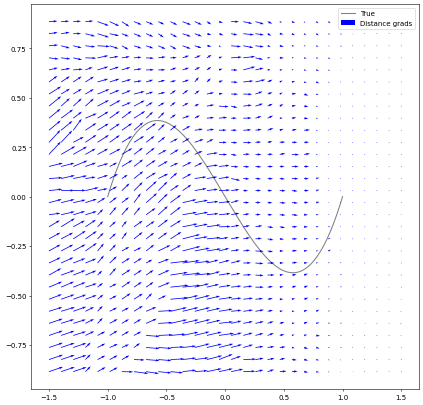

In [5]:
eps = 0.5
density = 30
plot_dist_grads(base_dataset.points, corrected_manifold, eps, density)

Here are some examples of the metric tensor field for different settings of the correction encoder.

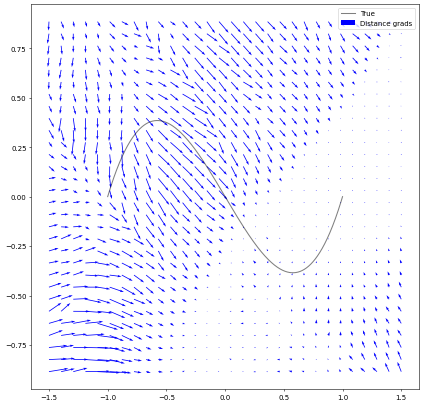

In [6]:
new_params = encoder_params.copy()
new_params['skip_connection'] = True
encoder = MLP2(**new_params)
corrected_manifold = CorrectedEuclideanManifold2(base_manifold_params, encoder, beta=100., learnable_beta=False)
plot_dist_grads(base_dataset.points, corrected_manifold, eps, density)

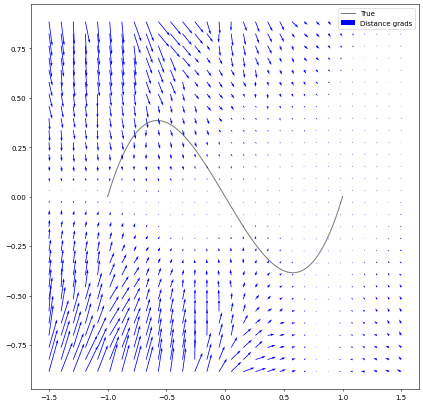

In [7]:
new_params = encoder_params.copy()
new_params['num_hidden_layers'] = 0
encoder = MLP2(**new_params)
corrected_manifold = CorrectedEuclideanManifold2(base_manifold_params, encoder, beta=100., learnable_beta=False)
plot_dist_grads(base_dataset.points, corrected_manifold, eps, density)

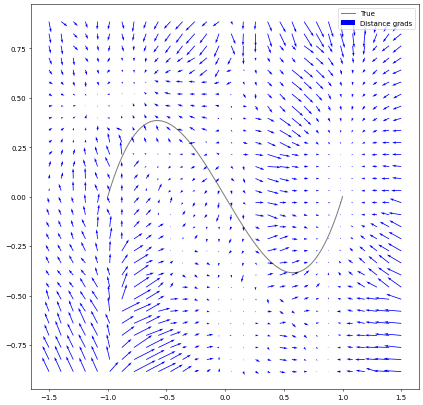

In [8]:
new_params = encoder_params.copy()
new_params['num_hidden_layers'] = 1
encoder = MLP2(**new_params)
corrected_manifold = CorrectedEuclideanManifold2(base_manifold_params, encoder, beta=100.,
                                                                     learnable_beta=False)
plot_dist_grads(base_dataset.points, corrected_manifold, eps, density)

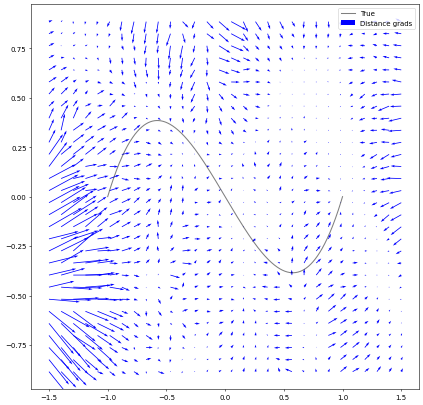

In [9]:
new_params = encoder_params.copy()
new_params['num_hidden_layers'] = 3
encoder = MLP2(**new_params)
corrected_manifold = CorrectedEuclideanManifold2(base_manifold_params, encoder, beta=100.,
                                                                     learnable_beta=False)
plot_dist_grads(base_dataset.points, corrected_manifold, eps, density)

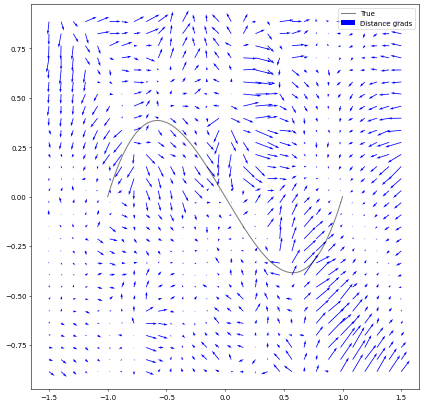

In [10]:
new_params = encoder_params.copy()
new_params['num_hidden_layers'] = 4
encoder = MLP2(**new_params)
corrected_manifold = CorrectedEuclideanManifold2(base_manifold_params, encoder, beta=100.,
                                                                     learnable_beta=False)
plot_dist_grads(base_dataset.points, corrected_manifold, eps, density)

# Fourier embeddings

Next we will introduce Fourier embeddings. We have three main parameters to set:
- number of Fourier features to sample `fourier_features`
- append or not the original features to the Fourier features `append`
- initialization of B matrix `B_init`. If not provided, B will be sampled from standard normal distribution.

To ensure compatibility of encoder with the corrected manifold, we need the encoder to be a child of `EuclideanPointEncoder`. Therefore I provide a simple wrapper which stacks a MLP on top of embeddings.

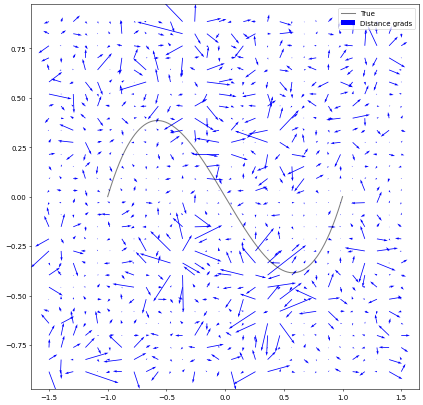

In [11]:
from src.metric_learning.euclidean import EuclideanPointEncoder, FourierEmbedding
import torch.nn as nn

in_features = base_dataset.points.shape[1]
fourier_features = 2048
append = False
B = None
embedding = FourierEmbedding(in_features, fourier_features, append=append, B_init=B)

new_params = encoder_params.copy()
emb_features = 2 * fourier_features if not append else in_features + 2 * fourier_features
new_params['in_features'] = emb_features
mlp = MLP2(**new_params)

class FourierMLP(EuclideanPointEncoder):
    def __init__(self, embedding, mlp):
        super().__init__(embedding.input_dim, mlp.output_dim)
        self.embedding = embedding
        self.mlp = mlp
        
    def forward(self, x):
        return self.mlp(self.embedding(x))
        
encoder = FourierMLP(embedding, mlp)
corrected_manifold = CorrectedEuclideanManifold2(base_manifold_params, encoder, beta=100.,
                                                                     learnable_beta=False)
plot_dist_grads(base_dataset.points, corrected_manifold, eps, density)

Let's see how distance grads change for trained network. To add a regularization term I use the `CurveNegativeRegularizer` class. It computes the hessian of the squared correction function and adds a maximization term to the loss function (therefore *negative*). It has two parameters, `neg_hess_weight` and `max_neg_hess_norm`. The first one is the weight of the regularization term, and the second one is the maximum norm of the Hessian norms at the sampled locations (this regularizer aims to maximize the Hessian norms at the curve points). If the mean Hessian norm exceeds the maximum norm, it is clamped to `max_neg_hess_norm`. This is to prevent the regularization term from dominating the loss function.

In [12]:
from src.metric_learning.regularizers import CurveNegativeRegularizer

class Trainer:
    def __init__(self, manifold, optimizer, regularizer_weight=10.):
        self.manifold = manifold
        self.optimizer = optimizer
        self.regularizer = CurveNegativeRegularizer(manifold.correction_encoder, 
                                                    neg_hess_weight=regularizer_weight,
                                                    max_neg_hess_norm=1e-1)

    def training_step(self, x):
        self.optimizer.zero_grad()
        
        # 1. compute the main loss, based on the geodesic equation
        x1 = x[:, :-1, :]  # dimensions: (B, L-1, D)
        x2 = x[:, 1:, :]  # dimensions: (B, L-1, D)
        corrected_dists = self.manifold.distance(x1, x2)
        lhs = torch.sum(corrected_dists, dim=1) ** 2
        rhs = corrected_dists.shape[1] * torch.sum(corrected_dists ** 2, dim=1)
        g_loss = nn.functional.mse_loss(lhs, rhs)
        
        # 2. compute the hessian norms for both types of samples
        out = self.regularizer(x)
        pos_mean_hess_loss = out['pos_mean_hess_loss']
        neg_mean_hess_loss = out['neg_mean_hess_loss']
        
        # 3. compute the final loss
        loss = g_loss + pos_mean_hess_loss + neg_mean_hess_loss
        
        loss.backward()
        
        self.optimizer.step()
        
    def train(self, n_epochs, curve):
        for i, epoch in enumerate(range(n_epochs)):
            print(f'Epoch {i+1}/{n_epochs}')
            self.training_step(curve)

We need to specify one last thing, which is the optimizer. I found that Adam with a learning rate of 1e-3 works well for Fourier-based networks. For ReLU MLPs, there was a need to increase the learning rate over the first 100-200 epochs.

Epoch 1/50
Epoch 2/50
Epoch 3/50
Epoch 4/50
Epoch 5/50
Epoch 6/50
Epoch 7/50
Epoch 8/50
Epoch 9/50
Epoch 10/50
Epoch 11/50
Epoch 12/50
Epoch 13/50
Epoch 14/50
Epoch 15/50
Epoch 16/50
Epoch 17/50
Epoch 18/50
Epoch 19/50
Epoch 20/50
Epoch 21/50
Epoch 22/50
Epoch 23/50
Epoch 24/50
Epoch 25/50
Epoch 26/50
Epoch 27/50
Epoch 28/50
Epoch 29/50
Epoch 30/50
Epoch 31/50
Epoch 32/50
Epoch 33/50
Epoch 34/50
Epoch 35/50
Epoch 36/50
Epoch 37/50
Epoch 38/50
Epoch 39/50
Epoch 40/50
Epoch 41/50
Epoch 42/50
Epoch 43/50
Epoch 44/50
Epoch 45/50
Epoch 46/50
Epoch 47/50
Epoch 48/50
Epoch 49/50
Epoch 50/50


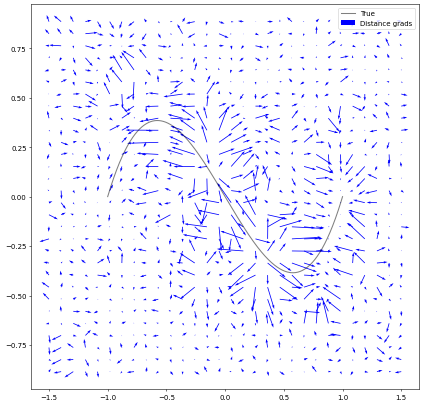

In [13]:
encoder_opt = torch.optim.Adam(encoder.parameters(), lr=1e-3)
trainer = Trainer(corrected_manifold, encoder_opt)
trainer.train(50, base_dataset.points[None])
plot_dist_grads(base_dataset.points, corrected_manifold, eps, density)

Following the Fourier embeddings paper, standard deviation of distribution from which we sample the B matrix entries is crucial. It basically controls the magnitude of the Fourier features. Too low = underfitting, too high - overfitting. We should tune it separately for each dataset. 

Epoch 1/50
Epoch 2/50
Epoch 3/50
Epoch 4/50
Epoch 5/50
Epoch 6/50
Epoch 7/50
Epoch 8/50
Epoch 9/50
Epoch 10/50
Epoch 11/50
Epoch 12/50
Epoch 13/50
Epoch 14/50
Epoch 15/50
Epoch 16/50
Epoch 17/50
Epoch 18/50
Epoch 19/50
Epoch 20/50
Epoch 21/50
Epoch 22/50
Epoch 23/50
Epoch 24/50
Epoch 25/50
Epoch 26/50
Epoch 27/50
Epoch 28/50
Epoch 29/50
Epoch 30/50
Epoch 31/50
Epoch 32/50
Epoch 33/50
Epoch 34/50
Epoch 35/50
Epoch 36/50
Epoch 37/50
Epoch 38/50
Epoch 39/50
Epoch 40/50
Epoch 41/50
Epoch 42/50
Epoch 43/50
Epoch 44/50
Epoch 45/50
Epoch 46/50
Epoch 47/50
Epoch 48/50
Epoch 49/50
Epoch 50/50


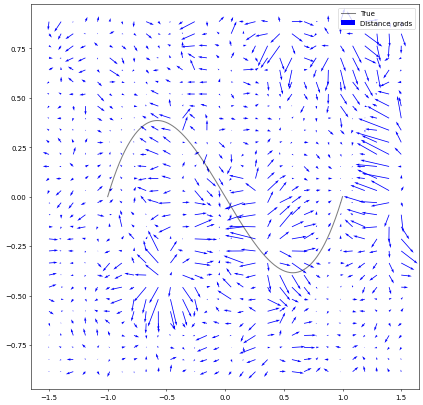

In [18]:
from src.metric_learning.euclidean import EuclideanPointEncoder, FourierEmbedding

in_features = base_dataset.points.shape[1]
fourier_features = 2048
append = False

mu = torch.zeros(fourier_features, in_features)
sigma = 0.5
B = torch.normal(mu, sigma)
embedding = FourierEmbedding(in_features, fourier_features, append=append, B_init=B)

emb_features = 2 * fourier_features if not append else in_features + 2 * fourier_features
encoder_params = {
    'in_features': emb_features,
    'hidden_features': 64,
    'out_features': 2,
    'num_hidden_layers': 2,
    'outermost_linear': True,
    'nonlinearity': 'relu',
    'skip_connection': False,
}

mlp = MLP2(**encoder_params)

class FourierMLP(EuclideanPointEncoder):
    def __init__(self, embedding, mlp):
        super().__init__(embedding.input_dim, mlp.output_dim)
        self.embedding = embedding
        self.mlp = mlp
        
    def forward(self, x):
        return self.mlp(self.embedding(x))
        
encoder = FourierMLP(embedding, mlp)
corrected_manifold = CorrectedEuclideanManifold2(base_manifold_params, encoder, beta=100.,
                                                                     learnable_beta=False)
trainer = Trainer(corrected_manifold, encoder_opt)
trainer.train(50, base_dataset.points[None])
plot_dist_grads(base_dataset.points, corrected_manifold, eps, density)

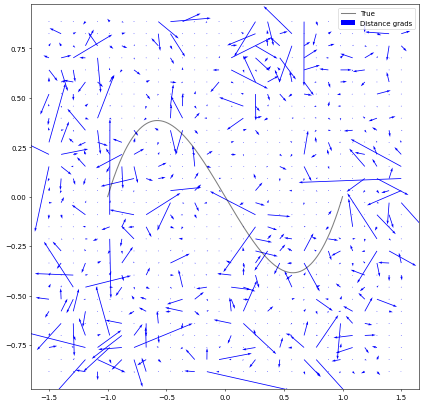

In [254]:
from src.metric_learning.euclidean import EuclideanPointEncoder, FourierEmbedding
import torch.nn as nn

in_features = base_dataset.points.shape[1]
fourier_features = 2048
append = False

mu = torch.zeros(fourier_features, in_features)
sigma = 1.5
B = torch.normal(mu, sigma)
embedding = FourierEmbedding(in_features, fourier_features, append=append, B_init=B)

emb_features = 2 * fourier_features if not append else in_features + 2 * fourier_features
encoder_params = {
    'in_features': emb_features,
    'hidden_features': 64,
    'out_features': 2,
    'num_hidden_layers': 2,
    'outermost_linear': True,
    'nonlinearity': 'relu',
    'skip_connection': False,
}

mlp = MLP2(**encoder_params)

class FourierMLP(EuclideanPointEncoder):
    def __init__(self, embedding, mlp):
        super().__init__(embedding.input_dim, mlp.output_dim)
        self.embedding = embedding
        self.mlp = mlp
        
    def forward(self, x):
        return self.mlp(self.embedding(x))
        
encoder = FourierMLP(embedding, mlp)
corrected_manifold = CorrectedEuclideanManifold(base_manifold_params, encoder, beta=100.,
                                                                     learnable_beta=False)
trainer = Trainer(corrected_manifold, encoder_opt)
trainer.train(50, base_dataset.points[None])
plot_dist_grads(base_dataset.points, corrected_manifold, eps, density)

The smoothness of the learned gradient fields is heavily influenced by the number of Fourier features. The more features, the smoother the gradients. We need to add L2 regularization to prevent overfitting coming from the wide hidden layers. We also pull down sigma to 0.7 for the same reason.

I was not able to get good results with less than 2048 Fourier freqs. After that threshold, increasing makes the field just smoother. This is not optimistic for the scaling of the needed Fourier features with the dimensionality of the input space. Authors claim that with MLP on top, we can use sparse sampling, but I couldn't make it work.

Epoch 1/200
Epoch 2/200
Epoch 3/200
Epoch 4/200
Epoch 5/200
Epoch 6/200
Epoch 7/200
Epoch 8/200
Epoch 9/200
Epoch 10/200
Epoch 11/200
Epoch 12/200
Epoch 13/200
Epoch 14/200
Epoch 15/200
Epoch 16/200
Epoch 17/200
Epoch 18/200
Epoch 19/200
Epoch 20/200
Epoch 21/200
Epoch 22/200
Epoch 23/200
Epoch 24/200
Epoch 25/200
Epoch 26/200
Epoch 27/200
Epoch 28/200
Epoch 29/200
Epoch 30/200
Epoch 31/200
Epoch 32/200
Epoch 33/200
Epoch 34/200
Epoch 35/200
Epoch 36/200
Epoch 37/200
Epoch 38/200
Epoch 39/200
Epoch 40/200
Epoch 41/200
Epoch 42/200
Epoch 43/200
Epoch 44/200
Epoch 45/200
Epoch 46/200
Epoch 47/200
Epoch 48/200
Epoch 49/200
Epoch 50/200
Epoch 51/200
Epoch 52/200
Epoch 53/200
Epoch 54/200
Epoch 55/200
Epoch 56/200
Epoch 57/200
Epoch 58/200
Epoch 59/200
Epoch 60/200
Epoch 61/200
Epoch 62/200
Epoch 63/200
Epoch 64/200
Epoch 65/200
Epoch 66/200
Epoch 67/200
Epoch 68/200
Epoch 69/200
Epoch 70/200
Epoch 71/200
Epoch 72/200
Epoch 73/200
Epoch 74/200
Epoch 75/200
Epoch 76/200
Epoch 77/200
Epoch 78

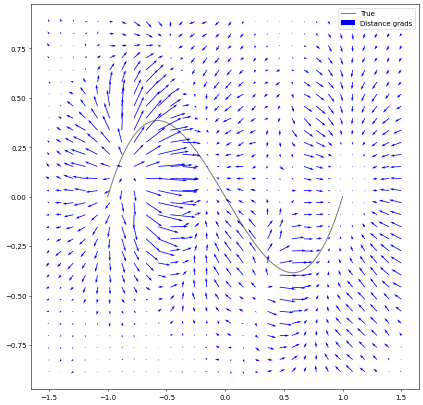

In [23]:
from src.metric_learning.euclidean import EuclideanPointEncoder, FourierEmbedding
import torch.nn as nn

base_dataset = ThirdDegreePolynomialDataset(a=-1, b=0, c=1, n_points=1000, center=True)

in_features = base_dataset.points.shape[1]
fourier_features = 2048
append = False

mu = torch.zeros(fourier_features, in_features)
sigma = 0.5
B = torch.normal(mu, sigma)
embedding = FourierEmbedding(in_features, fourier_features, append=append, B_init=B)

emb_features = 2 * fourier_features if not append else in_features + 2 * fourier_features
encoder_params = {
    'in_features': emb_features,
    'hidden_features': 1024,
    'out_features': 2,
    'num_hidden_layers': 2,
    'outermost_linear': True,
    'nonlinearity': 'relu',
    'skip_connection': False,
}

mlp = MLP2(**encoder_params)

class FourierMLP(EuclideanPointEncoder):
    def __init__(self, embedding, mlp):
        super().__init__(embedding.input_dim, mlp.output_dim)
        self.embedding = embedding
        self.mlp = mlp
        
    def forward(self, x):
        return self.mlp(self.embedding(x))
        
encoder = FourierMLP(embedding, mlp)
corrected_manifold = CorrectedEuclideanManifold2(base_manifold_params, encoder, beta=100.,
                                                                     learnable_beta=False)
encoder_opt = torch.optim.Adam(encoder.parameters(), lr=1e-3, weight_decay=1e-3)
trainer = Trainer(corrected_manifold, encoder_opt)
trainer.train(200, base_dataset.points[None])
plot_dist_grads(base_dataset.points, corrected_manifold, eps, density)

Let's check how it performs in the interpolation task.

torch.Size([1, 1, 2, 2])
torch.Size([1, 1, 2, 2])
1 | relerror = 4.7251129150390625
torch.Size([1, 1, 2, 2])
torch.Size([1, 1, 2, 2])
2 | relerror = 14.953667640686035
torch.Size([1, 1, 2, 2])
torch.Size([1, 1, 2, 2])
3 | relerror = 0.47687387466430664
torch.Size([1, 1, 2, 2])
torch.Size([1, 1, 2, 2])
4 | relerror = 14.365480422973633
torch.Size([1, 1, 2, 2])
torch.Size([1, 1, 2, 2])
5 | relerror = 13.05023193359375
torch.Size([1, 1, 2, 2])
torch.Size([1, 1, 2, 2])
6 | relerror = 8.29091739654541
torch.Size([1, 1, 2, 2])
torch.Size([1, 1, 2, 2])
7 | relerror = 10.897482872009277
torch.Size([1, 1, 2, 2])
torch.Size([1, 1, 2, 2])
8 | relerror = 4.992789268493652
torch.Size([1, 1, 2, 2])
torch.Size([1, 1, 2, 2])
9 | relerror = 11.062067031860352
torch.Size([1, 1, 2, 2])
torch.Size([1, 1, 2, 2])
10 | relerror = 8.746944427490234
torch.Size([1, 1, 2, 2])
torch.Size([1, 1, 2, 2])
11 | relerror = 17.57990074157715
torch.Size([1, 1, 2, 2])
torch.Size([1, 1, 2, 2])
12 | relerror = 18.9585971832

KeyboardInterrupt: 

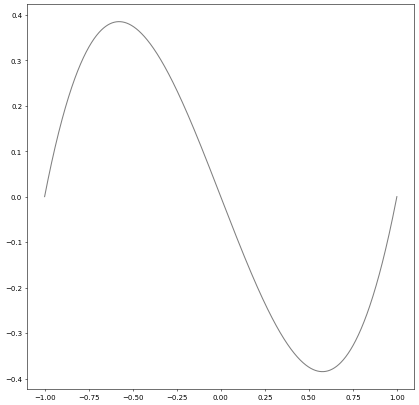

In [27]:
plot_geodesics(base_dataset.points, corrected_manifold, 0, 200, 10)

I also wanted to show the performance of Fourier networks on a different dataset. Here we need to pull down sigma even lower to achieve the nice pattern. We still get bad interpolation results though.

Epoch 1/50
Epoch 2/50
Epoch 3/50
Epoch 4/50
Epoch 5/50
Epoch 6/50
Epoch 7/50
Epoch 8/50
Epoch 9/50
Epoch 10/50
Epoch 11/50
Epoch 12/50
Epoch 13/50
Epoch 14/50
Epoch 15/50
Epoch 16/50
Epoch 17/50
Epoch 18/50
Epoch 19/50
Epoch 20/50
Epoch 21/50
Epoch 22/50
Epoch 23/50
Epoch 24/50
Epoch 25/50
Epoch 26/50
Epoch 27/50
Epoch 28/50
Epoch 29/50
Epoch 30/50
Epoch 31/50
Epoch 32/50
Epoch 33/50
Epoch 34/50
Epoch 35/50
Epoch 36/50
Epoch 37/50
Epoch 38/50
Epoch 39/50
Epoch 40/50
Epoch 41/50
Epoch 42/50
Epoch 43/50
Epoch 44/50
Epoch 45/50
Epoch 46/50
Epoch 47/50
Epoch 48/50
Epoch 49/50
Epoch 50/50
1 | relerror = 5.142355442047119
2 | relerror = 0.8060393929481506
3 | relerror = 1.0852714776992798
4 | relerror = 2.7876713275909424
5 | relerror = 0.8182128071784973
6 | relerror = 0.6613247394561768
7 | relerror = 0.808871865272522
8 | relerror = 0.2671279311180115
9 | relerror = 0.1314011812210083
10 | relerror = 0.18633607029914856
11 | relerror = 0.3353722393512726
12 | relerror = 0.4102234840393066

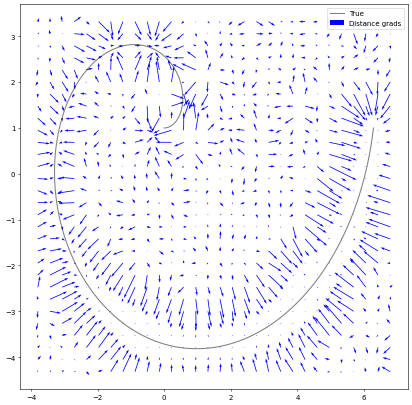

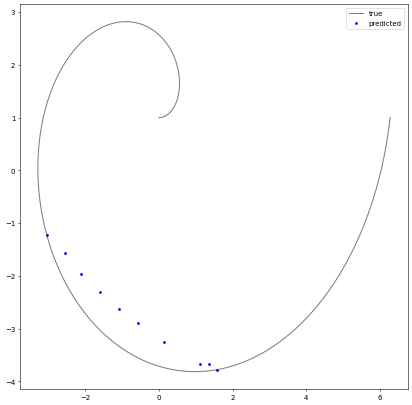

In [270]:
from src.datasets.euclidean import ThirdDegreePolynomialDataset, SpiralDataset

n_points = 1000
base_dataset = SpiralDataset(0, 2. * torch.pi, n_points=n_points, center=True)

in_features = base_dataset.points.shape[1]
fourier_features = 2048
append = False

mu = torch.zeros(fourier_features, in_features)
sigma = 0.3
B = torch.normal(mu, sigma)
embedding = FourierEmbedding(in_features, fourier_features, append=append,
                             B_init=B)

emb_features = 2 * fourier_features if not append else in_features + 2 * fourier_features
new_params = {
    'in_features': emb_features,
    'hidden_features': 1024,
    'out_features': 2,
    'num_hidden_layers': 2,
    'outermost_linear': True,
    'nonlinearity': 'relu',
    'skip_connection': False,
}

mlp = MLP2(**new_params)

class FourierMLP(EuclideanPointEncoder):
    def __init__(self, embedding, mlp):
        super().__init__(embedding.input_dim, 2)
        self.embedding = embedding
        self.mlp = mlp
        
    def forward(self, x):
        return self.mlp(self.embedding(x))
        
encoder = FourierMLP(embedding, mlp)
encoder_opt = torch.optim.Adam(encoder.parameters(), lr=1e-3, weight_decay=1e-3)
corrected_manifold = CorrectedEuclideanManifold(base_manifold_params, encoder, beta=100.,
                                                                     learnable_beta=False)
trainer = Trainer(corrected_manifold, encoder_opt)
trainer.train(50, base_dataset.points[None])
plot_dist_grads(base_dataset.points, corrected_manifold, eps, density)
plot_geodesics(base_dataset.points, corrected_manifold, 600, 800, 10)

Last idea - mixing MLP operating on coordinates with Fourier MLP. Does not help but it was the last that I tried :) I want to somehow combine the expressivity of the Fourier networks with the interpolation abilities of coordinate MLP. I would put a hypothesis here that 
- coordinate MLPs produce flow-like gradient fields which aid in interpolation
- Fourier MLPs provide sufficient expressivity but the gradient field induced by them is a spatial superposition of the bumps corresponding to frequencies (with gradients pointing outwards) therefore it's naturally less flow-like. It is represented by big troubles in the interpolation task convergence.

Maybe tuning sigma can help here... Either way, maybe some of the proposed regularization schemes will ensure that the Fourier MLPs will produce more flow-like gradient fields. Right we don't really represent that in the loss function.

Epoch 1/50
Epoch 2/50
Epoch 3/50
Epoch 4/50
Epoch 5/50
Epoch 6/50
Epoch 7/50
Epoch 8/50
Epoch 9/50
Epoch 10/50
Epoch 11/50
Epoch 12/50
Epoch 13/50
Epoch 14/50
Epoch 15/50
Epoch 16/50
Epoch 17/50
Epoch 18/50
Epoch 19/50
Epoch 20/50
Epoch 21/50
Epoch 22/50
Epoch 23/50
Epoch 24/50
Epoch 25/50
Epoch 26/50
Epoch 27/50
Epoch 28/50
Epoch 29/50
Epoch 30/50
Epoch 31/50
Epoch 32/50
Epoch 33/50
Epoch 34/50
Epoch 35/50
Epoch 36/50
Epoch 37/50
Epoch 38/50
Epoch 39/50
Epoch 40/50
Epoch 41/50
Epoch 42/50
Epoch 43/50
Epoch 44/50
Epoch 45/50
Epoch 46/50
Epoch 47/50
Epoch 48/50
Epoch 49/50
Epoch 50/50
1 | relerror = 3.8578643798828125
2 | relerror = 1.0723623037338257
3 | relerror = 6.576396942138672
4 | relerror = 0.42812275886535645
5 | relerror = 0.9421808123588562
6 | relerror = 3.1172897815704346
7 | relerror = 3.9076077938079834
8 | relerror = 1.9030587673187256
9 | relerror = 0.5662384629249573
10 | relerror = 0.5516753792762756
11 | relerror = 0.03953464701771736
12 | relerror = 0.03378586098551

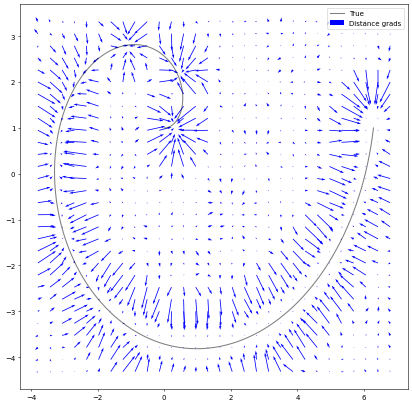

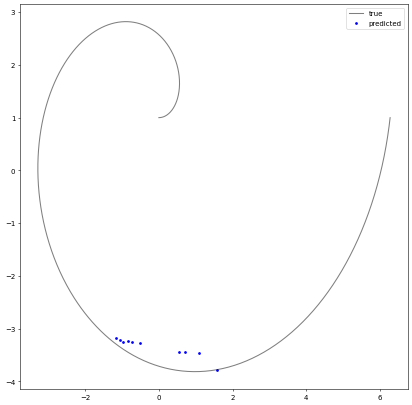

In [272]:
from src.datasets.euclidean import SpiralDataset

n_points = 1000
base_dataset = SpiralDataset(0, 2. * torch.pi, n_points=n_points, center=True)

# 1. Base network
base_mlp_params = {
    'in_features': base_dataset.points.shape[1],
    'hidden_features': 256,
    'out_features': 2,
    'num_hidden_layers': 2,
    'outermost_linear': True,
    'nonlinearity': 'relu',
    'skip_connection': False,
}
base_mlp = MLP2(**base_mlp_params)

# 2. Fourier network
in_features = base_dataset.points.shape[1]
fourier_features = 4096
append = False
emb_features = 2 * fourier_features if not append else in_features + 2 * fourier_features
mu = torch.zeros(fourier_features, in_features)
sigma = 0.3
B = torch.normal(mu, sigma)
embedding = FourierEmbedding(in_features, fourier_features, append=append,
                             B_init=B)

fourier_mlp_params = {
    'in_features': emb_features,
    'hidden_features': 2048,
    'out_features': 2,
    'num_hidden_layers': 2,
    'outermost_linear': True,
    'nonlinearity': 'relu',
    'skip_connection': False,
}

fourier_mlp = MLP2(**fourier_mlp_params)

class FourierMLP2(EuclideanPointEncoder):
    def __init__(self, base_mlp, embedding, fourier_mlp, weights=(1., 1.)):
        super().__init__(base_mlp.input_dim, 2)
        self.base_mlp = base_mlp
        
        self.embedding = embedding
        self.fourier_mlp = fourier_mlp
        
        self.proj = nn.Linear(4, 2)
        
    def forward(self, x):
        base_out = self.base_mlp(x)
        f_out =  self.fourier_mlp(self.embedding(x))
        out = self.proj(torch.cat([base_out, f_out], dim=1))
        return out
        
encoder = FourierMLP2(base_mlp, embedding, fourier_mlp)
encoder_opt = torch.optim.Adam(encoder.parameters(), lr=1e-3, weight_decay=1e-3)
corrected_manifold = CorrectedEuclideanManifold(base_manifold_params, encoder, beta=100.,
                                                                     learnable_beta=False)
trainer = Trainer(corrected_manifold, encoder_opt)
trainer.train(50, base_dataset.points[None])
plot_dist_grads(base_dataset.points, corrected_manifold, eps, density)
plot_geodesics(base_dataset.points, corrected_manifold, 600, 800, 10)